# Challenge: Preparing a Dataset for Modeling
### Problem Statement
Using a dataset of your choice, select an outcome variable and then pick four or five other variables (one to two categorical, three to four continuous) to act as the basis for features. Explore the variables using the univariate and bivariate methods you've learned so far.

Next, based on what you learned via your data exploration, create ten new features. Explain the reasoning behind each one.

Finally, use filtering methods to select the five best features and justify your choices.
### Outline
1. Exploring the data
2. Creating 10 new features
3. Filter methods

# 1. Exploring the data

In [1]:
%matplotlib inline
import numpy as np
import scipy.stats as st
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# data
PATH = "data/opusdata.csv"
df = pd.read_csv(PATH)
target = df['international_box_office']
movie_name = df['movie_name']
df.drop(['movie_name', 'movie_odid', 'creative_type', 'source', 'production_method', 'sequel', 'running_time'], axis = 1, inplace = True)
print ("Number of rows: {}\nNumber of features: {}\nTarget feature: 'international_box_office'".format(len(df.index), len(df.columns) - 1))
df.head(3)

Number of rows: 1784
Number of features: 5
Target feature: 'international_box_office'


,production_year,production_budget,domestic_box_office,international_box_office,rating,genre
0,2006,10000000,2893666,366513,PG-13,Drama
1,2006,10000000,11748661,175380,PG-13,Drama
2,2006,10000000,1430721,31000000,Not Rated,Action


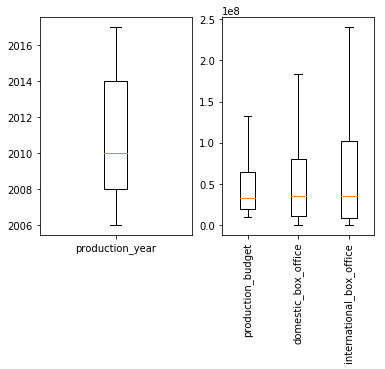

The distributions of continuous variables are displayed above as boxplots. Notice that the upper cap of international_box_office extends the furthest. This means that there are a few massively successful films that stand out in box office sales.


In [3]:
# boxplot of each continuous variable
# first year because of  the y-scale
fig_box, (ax_year, ax_money) = plt.subplots(1,2)
ax_year.boxplot(df['production_year'])
ax_year.set_xticklabels(['production_year'])
# then budgets and box offices
ax_money.boxplot([df['production_budget'], df['domestic_box_office'], df['international_box_office']], showfliers = False)
ax_money.set_xticklabels(['production_budget', 'domestic_box_office', 'international_box_office'], rotation = 90)
plt.show()
# discussion
print ("The distributions of continuous variables are displayed above as boxplots. Notice that the upper cap of international_box_office extends the furthest. This means that there are a few massively successful films that stand out in box office sales.")

/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_axes.py:6448: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


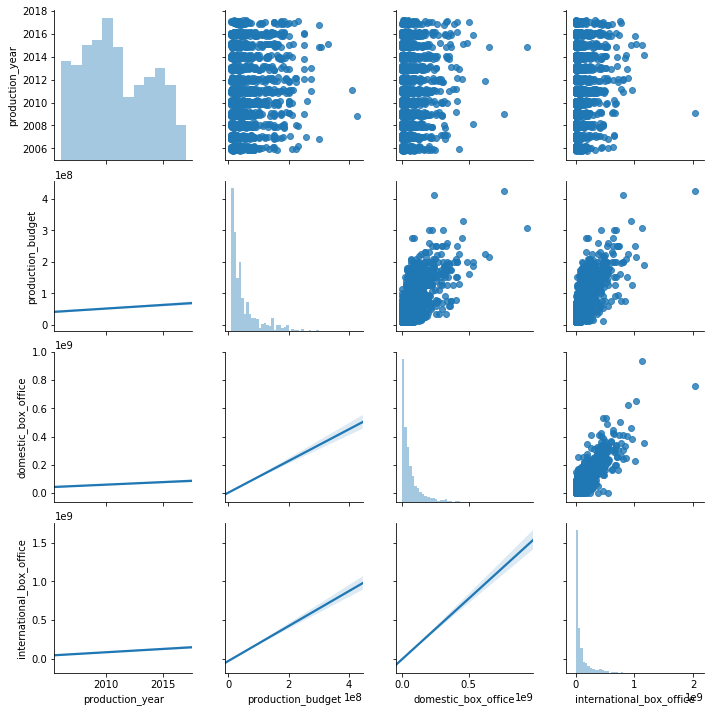

The pair grid shows distributions along the diagonal, linear regression in the lower half and scatter plot in the upper half. Notice the slope between international_box_office and both production_budget and domestic_box_office. These two variable may be our best features for predicting international_box_office.


In [4]:
# PairGrid showing histograms and correlations
q = sns.PairGrid(df,  diag_sharey=False)
q.map_diag(sns.distplot, kde = False)
q.map_lower(sns.regplot, scatter = False)
q.map_upper(sns.regplot, y_jitter = 0.2, fit_reg = False)
plt.show()
# discussion
print ("The pair grid shows distributions along the diagonal, linear regression in the lower half and scatter plot in the upper half. Notice the slope between international_box_office and both production_budget and domestic_box_office. These two variable may be our best features for predicting international_box_office.")

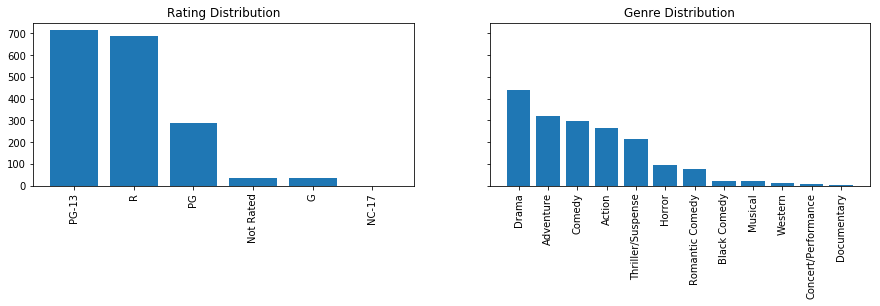

The distributions of the categorical variables shows an unbalanced favoring. Creating subcategories may help balance these out.


In [5]:
# distributions of rating and genre
ratings = df['rating'].value_counts()
genres = df['genre'].value_counts()
# plot
fig_bar, (ax_rating, ax_genre) = plt.subplots(1,2, sharey = True, figsize = (15,3))
ax_rating.bar(ratings.index, ratings)
ax_rating.set_xticklabels(ratings.index, rotation = 90)
ax_rating.set_title('Rating Distribution')
ax_genre.bar(genres.index, genres)
ax_genre.set_xticklabels(genres.index, rotation = 90)
ax_genre.set_title('Genre Distribution')
plt.show()
# discussion
print ("The distributions of the categorical variables shows an unbalanced favoring. Creating subcategories may help balance these out.")

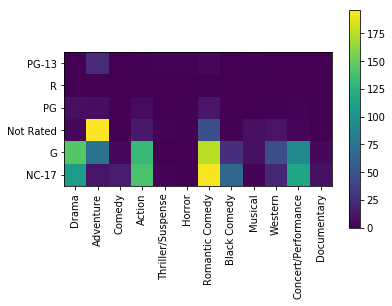

The cross tab chart shows how many rows contain both values of rating and genre. Here, there are many rows of Adventure films that are Not Rated as well as Comedy movies that are NC-17.


In [6]:
# cross tab - shows count of each combination of rating and genre
rating_genre_cross = pd.crosstab(df['rating'], df['genre'], rownames = ['rating'], colnames = ['genre'])
# plot
plt.imshow(rating_genre_cross)
plt.colorbar(orientation='vertical')
plt.yticks(range(len(ratings.index)), ratings.index)
plt.xticks(range(len(genres.index)), genres.index, rotation = 90)
plt.show()
# discussion
print ("The cross tab chart shows how many rows contain both values of rating and genre. Here, there are many rows of Adventure films that are Not Rated as well as Comedy movies that are NC-17.")

# 2. Create 10 new features

In [7]:
df_eng = df.copy()
# intense film
# binary classification (action, adventure, thriller/suspense, and horror)
df_eng['intense_film'] = (df['genre'].isin(['Action', 'Adventure', 'Thriller/Suspense', 'Horror']))
df_eng['intense_film'] = df_eng['intense_film'].astype(int)

# inappropriate film 
# binary classification (Not Rated, NC-17 and R)
df_eng['inappropriate_film'] = (df['rating'].isin(['Not Rated', 'NC-17', 'R']))
df_eng['inappropriate_film'] = df_eng['inappropriate_film'].astype(int)


# normalized year
# scale from "not quite 0" to 1, distance between years now has meaning
df_eng['normalized_year'] = ((df['production_year'] - df['production_year'].min() + 0.001) / df['production_year'].max() * 1.0)

# budget in millions
# divide budget by 1,000,000, round off
df_eng['budget_millions'] = df['production_budget'] / 1000000

# profit
# domestic - budget, can be negative
profit = np.array(df['domestic_box_office'] - df['production_budget'])
df_eng['profit'] = profit

# square root domestic
# make small domestic smaller and large domestic more comparable
df_eng['root_domestic'] = np.sqrt(df['domestic_box_office'])

# money rating
# lame (made <=10,000), ok (made <=100,000), great (made >100,000)
df_eng['lame_film'] = (profit <= 10000)
df_eng['lame_film'] = df_eng['lame_film'].astype(int)
df_eng['ok_film'] = ((profit > 10000) & (profit <= 1000000))
df_eng['ok_film'] = df_eng['ok_film'].astype(int)
df_eng['great_film'] = (profit > 1000000)
df_eng['great_film'] = df_eng['great_film'].astype(int)

# budget / normalized year
# divide budget by normalized year (effectively decreases budget value with increasing year)
df_eng['budget_per_year'] = df['production_budget'].div(df_eng['normalized_year'])

df_eng.head(3)

,production_year,production_budget,domestic_box_office,international_box_office,rating,genre,intense_film,inappropriate_film,normalized_year,budget_millions,profit,root_domestic,lame_film,ok_film,great_film,budget_per_year
0,2006,10000000,2893666,366513,PG-13,Drama,0,0,4.957858e-07,10.0,-7106334,1701.077894,1,0,0,2.017000e+13
1,2006,10000000,11748661,175380,PG-13,Drama,0,0,4.957858e-07,10.0,1748661,3427.631981,0,0,1,2.017000e+13
2,2006,10000000,1430721,31000000,Not Rated,Action,1,1,4.957858e-07,10.0,-8569279,1196.127502,1,0,0,2.017000e+13


# 3. Filter methods

In [8]:
# new dataframe for filtered features
df_filter = df_eng.copy()

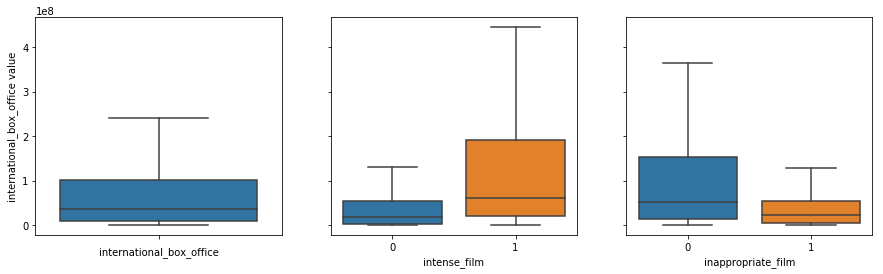

Here, we can see that one group of each subcategory (0 for intense_film and 1 for inappropriate_film) adequately represents the distribution of international_box_office. Therefore, we will drop the rating and genre features in lieu of this substitution.


In [9]:
# compare subcategory boxplots to international_box_office boxplot
fig_categoricals, (ax_international, ax_intense, ax_inappropriate) = plt.subplots(1,3, sharey = True, figsize = (15, 4))
sns.boxplot(data = df_eng['international_box_office'], showfliers = False, ax = ax_international)
ax_international.set_ylabel('international_box_office value')
ax_international.set_xlabel("international_box_office")
ax_international.set_xticklabels('')
sns.boxplot(x = 'intense_film', y = 'international_box_office', data = df_eng, showfliers = False, ax = ax_intense)
ax_intense. set_ylabel('')
sns.boxplot(x = 'inappropriate_film', y = 'international_box_office', data = df_eng, showfliers = False, ax = ax_inappropriate)
ax_inappropriate.set_ylabel('')
plt.show()
# discussion
print ("Here, we can see that one group of each subcategory (0 for intense_film and 1 for inappropriate_film) adequately represents the distribution of international_box_office. Therefore, we will drop the rating and genre features in lieu of this substitution.")

In [10]:
# drop rating and genre
df_filter.drop(labels = ['rating', 'genre'], axis = 1, inplace = True)

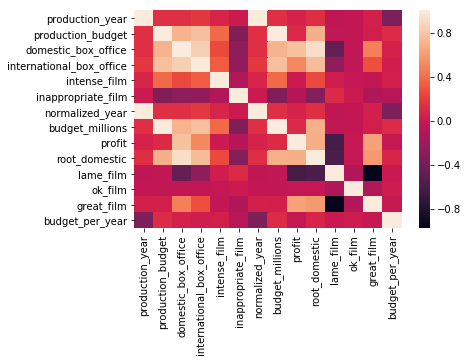

The correlation filter throws out continuous features that have a correlation between -0.2 and 0.2 with international_box_office


In [11]:
# correlation heatmap
eng_corr = df_eng.corr()
sns.heatmap(eng_corr)
plt.show()
# discussion
print ("The correlation filter throws out continuous features that have a correlation between -0.2 and 0.2 with international_box_office")

In [12]:
# correlation filtering
corr_drop = eng_corr.columns[(np.array(eng_corr['international_box_office']) < 0.2) & (np.array(eng_corr['international_box_office']) > -0.2)]
print ("Dropping..\n{}\n..due to insignificant correlation.".format(corr_drop))
df_filter.drop(labels = corr_drop, axis = 1, inplace = True)

Dropping..
Index(['production_year', 'normalized_year', 'ok_film', 'budget_per_year'], dtype='object')
..due to insignificant correlation.


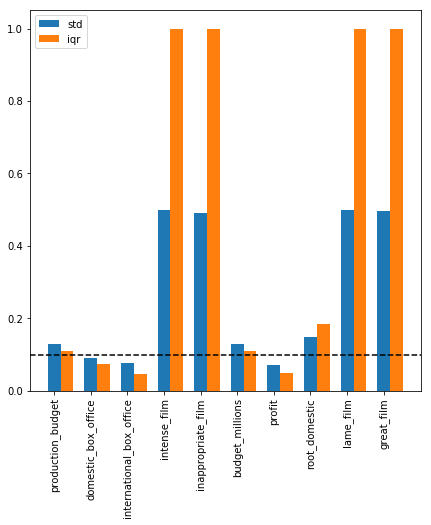

The standard deviation (std) and interquartile range (iqr) show the variance of each feature above. The continuous variables were min-max normalized in order to compare across all variables. Notice that binary variables have the highest variance. This is because all values are maximally separated on the scale from 0 to 1; each value can only be 0 or 1. Therefore, a low constraint of 0.1 drops features that have little variance, but keeps features that have moderate variance.


In [13]:
# variance filtering
# get std and IQR of each conitnuous variable
df_nums = df_filter.select_dtypes(exclude = 'object') # only work on numeric features
df_norm=(df_nums-df_nums.min())/(df_nums.max()-df_nums.min()) # min-max normalize each numeric for comparison
std = df_norm.std(axis = 0)
iqr = df_norm.quantile(q = 0.75, axis = 0) - df_norm.quantile(0.25, axis = 0)
# bar plot of std and iqr
variance_ind = np.array(range(len(std.index)))
variance_width = 0.35
plt.figure(figsize = (7,7))
plt.bar(variance_ind, std, width = variance_width, label = 'std')
plt.bar(variance_ind + variance_width, iqr, width = variance_width, label = 'iqr')
plt.axhline(0.1, linestyle = '--', color = 'k')
plt.xticks(variance_ind, std.index, rotation = 90)
plt.legend()
plt.show()
# discussion
print ("The standard deviation (std) and interquartile range (iqr) show the variance of each feature above. The continuous variables were min-max normalized in order to compare across all variables. Notice that binary variables have the highest variance. This is because all values are maximally separated on the scale from 0 to 1; each value can only be 0 or 1. Therefore, a low constraint of 0.1 drops features that have little variance, but keeps features that have moderate variance.")

In [14]:
# drop std below 0.1 and IQR below 0.1
variance_drop = std.index[np.array(std) < 0.1]
print ("Dropping..\n{}\n..due to insignificant variance".format(variance_drop))
df_filter.drop(labels = variance_drop, axis = 1, inplace = True)

Dropping..
Index(['domestic_box_office', 'international_box_office', 'profit'], dtype='object')
..due to insignificant variance


In [15]:
# finally, we'll use PCA to drop out the last 2 features that explain the least amount of variance in international_box_office
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA 

sklearn_pca = PCA(n_components=5)
df_pca = sklearn_pca.fit_transform(df_filter)

print(
    'The percentage of total variance in the dataset explained by each',
    'component from Sklearn PCA.\n',
    sklearn_pca.explained_variance_ratio_
)
# discussion
print ("\nPCA first determines the eigenvectors associated with the most variance in the data, and then reduces the set to the specified number of features. The first 5 eigenvectors are used. Notice that the first feature accounts for nearly all of the variance.")

The percentage of total variance in the dataset explained by each component from Sklearn PCA.
 [9.99999996e-01 3.75622216e-09 7.77921022e-17 7.39181505e-17
 6.59614695e-17]

PCA first determines the eigenvectors associated with the most variance in the data, and then reduces the set to the specified number of features. The first 5 eigenvectors are used. Notice that the first feature accounts for nearly all of the variance.
